In [1]:
import os
name = "Pretrained_ResNet50V2_Model"
load_model = True
save_model = False
train_again = False
working_dir = r"C:\Users\droko\Documents\קורסים\סדנה במדעי הנתונים\פרויקט"
saved_model_path = os.path.join(working_dir, f'{name}.h5')
saved_model_fit_results_path = os.path.join(working_dir, f'{name}_History.bin')

# Loading the data

In [2]:
data_dir = os.path.join(working_dir, "ChestXRays")

In [3]:
test_path = os.path.join(data_dir,'test')
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'val')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
            rescale=1/255.,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=0.3,
            width_shift_range=0.25,
            height_shift_range=0.25,
            channel_shift_range=0.35,
            shear_range=0.2,
            zoom_range=0.4)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path, class_mode="binary", batch_size=16, target_size=(224, 224))
validation_set = val_test_datagen.flow_from_directory(val_path, class_mode="binary", batch_size=16, target_size=(224, 224))
test_set = val_test_datagen.flow_from_directory(test_path, class_mode="binary", batch_size=16, target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building the model

## Load the pretrained model

In [5]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2

if os.path.exists(saved_model_path) and load_model:
    model = keras.models.load_model(saved_model_path)
else:
    base_model = ResNet50V2(weights="imagenet",
                            input_shape=(224, 224, 3),
                            pooling="max",
                            include_top=False,
                            classes=2)

    for layer in base_model.layers:
        layer.trainable = False

## Create more layers on top of the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

if not os.path.exists(saved_model_path) or not load_model:
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [8]:
import pickle

if os.path.exists(saved_model_fit_results_path) and not train_again:
    with open(saved_model_fit_results_path, "rb") as f:
        history = pickle.load(f)
else:
    results = model.fit(train_set, epochs=20, validation_data=validation_set, callbacks=[early_stop]) 
    history = results.history
    with open(saved_model_fit_results_path, 'wb') as f:
        pickle.dump(history, f)

In [9]:
if save_model:
    model.save(saved_model_path)

# Measure the trained model

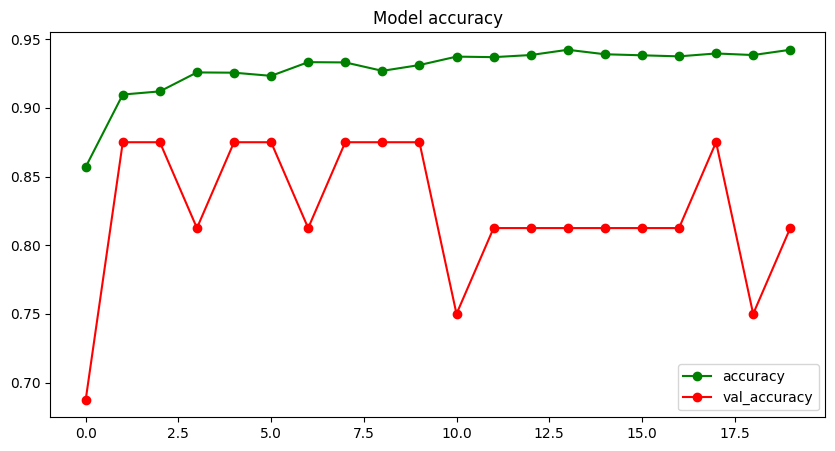

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Model accuracy")
plt.plot(history["accuracy"], "go-")
plt.plot(history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

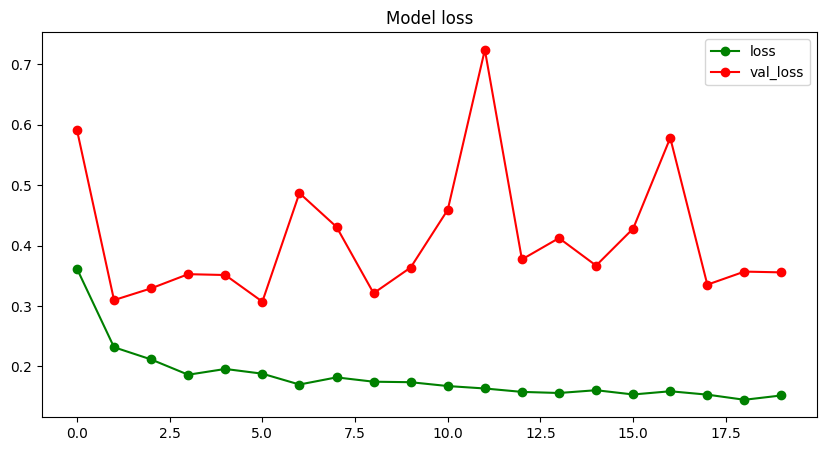

In [11]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history["loss"], "go-")
plt.plot(history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

# Evaluate the model on test set

In [12]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"The testing accuracy is: {test_accuracy*100}%")
print(f"The testing loss is: {test_loss*100}%")

39/39 [==============================] - 84s 2s/step - loss: 0.2343 - accuracy: 0.9135
The testing accuracy is: 91.34615659713745%
The testing loss is: 23.43433052301407%


# Prediction of an image

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image
import random

def predict(model, image_path):
    test_image = image.load_img(image_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image / 255

    result = model.predict(test_image)
    print(("PNEUMONIA" if result > 0.5 else "NORMAL") + f" [{str(result[0][0])}]")
    
normal_test_path = os.path.join(test_path, "NORMAL")
normal_image_path = os.path.join(normal_test_path, random.choice(os.listdir(normal_test_path)))
predict(model, normal_image_path)

pneumonia_test_path = os.path.join(test_path, "PNEUMONIA")
pneumonia_image_path = os.path.join(pneumonia_test_path, random.choice(os.listdir(pneumonia_test_path)))
predict(model, pneumonia_image_path)

1/1 [==============================] - 2s 2s/step
NORMAL [0.012535916]
1/1 [==============================] - 0s 135ms/step
PNEUMONIA [0.98010015]
